[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/elcursodeia-code/blob/master/ml/05_svm.ipynb)

# Support Vector Machines

## Clasificación lineal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/Users/sensio/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [2]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

Agregar más instancias fuera del margen no afectará el modelo. Este está completamente determinado por las instancias ubicadas en los bordes, los vectores de soporte. 

Esto se denomina clasificación de gran margen, pero solo funciona si los datos son linealmente separables. Para superar este problema, utilizamos la clasificación de margen suave, donde el objetivo es encontrar un buen equilibrio entre el margen y el número de valores atípicos. En Scikit-Learn, podemos controlar esto con el hiperparámetro C.

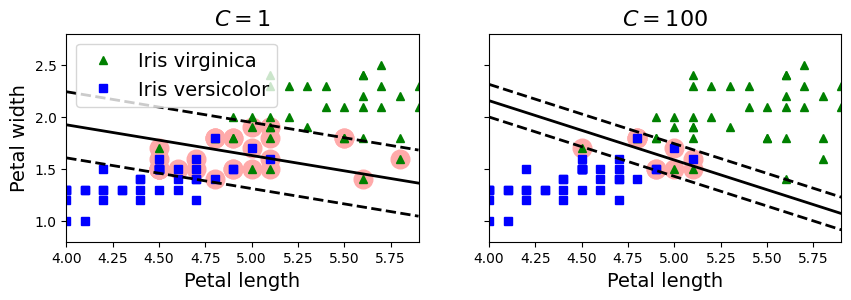

In [3]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.show()

El modelo clasificador SVM lineal predice la clase de una nueva instancia $\bf{x}$ calculando la función de decisión $\mathbf{w}^T \mathbf{x} + b = w_1 x_1 + w_2 x_2 + ... + w_n x_n + b$, donde $\bf{w}$ son los pesos del modelo y $b$ es su sesgo. Luego, se asigna una clase de acuerdo al signo

$$
\hat{y} = \left\{
  \begin{array}{lcr}
  0 & \textrm{if} & \mathbf{w}^T \mathbf{x} + b < 0\\
  1 & \textrm{if} &  \mathbf{w}^T \mathbf{x} + b \geq 0
  \end{array} \right.
$$

In [4]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

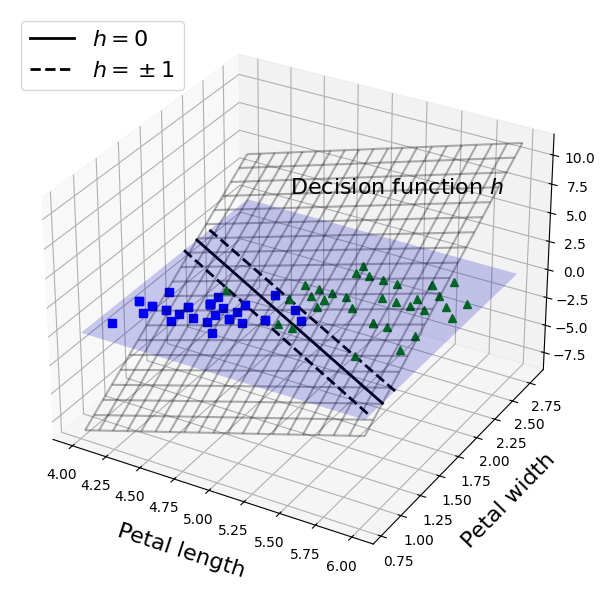

In [22]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    # ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    # ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])
plt.tight_layout()
plt.show()

El entrenamiento de un clasificador SVM lineal consiste en encontrar los valores de $\bf{w}$ y $b$ que maximizan el margen mientras se evitan violaciones del margen (margen duro) o se limitan (margen suave). Maximizar el margen significa minimizar $||\bf{w}||$.

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/svm_margin.png)

Si queremos evitar violaciones del margen, necesitamos que la función de decisión sea mayor que 1 para todas las instancias de entrenamiento positivas y menor que -1 para las instancias negativas. Esta restricción se puede expresar como $t^{(i)}(\mathbf{w}^T \mathbf{x} + b)\geq 1$ donde $t^{(i)}=-1$ para instancias negativas y $t^{(i)}=1$ para instancias positivas. Para permitir algunas violaciones del margen, introducimos la *variable de holgura* y el hiperparámetro $C$ para equilibrar entre las violaciones del margen y la maximización del margen. El problema final se define de la siguiente manera:

$$
  \begin{array}{ll}
    \underset{\mathbf{w},b,\zeta}{\textrm{minimize}} & \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \sum_{j=1}^N \zeta^{(j)}  \\
    \textrm{subject to} & t^{(j)}(\mathbf{w}^T \mathbf{x}^{(j)} + b)\geq 1 - \zeta^{(j)} & \textrm{and} & \zeta^{(j)} \geq 0 & \textrm{for} & i = 1, 2, ..., N
  \end{array}
$$

Este problema es un problema de optimización cuadrática con restricciones lineales, conocido como problema de *Programación Cuadrática* (QP, por sus siglas en inglés) (cuya resolución está fuera del alcance de esta lección).

SVM cumple las condiciones para resolver este problema en la *forma dual*, una forma alternativa que es mucho más rápida y permite el *truco del kernel*.

$$
  \begin{array}{l}
    \underset{\alpha}{\textrm{minimize}} & \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha^{(i)}\alpha^{(j)}t^{(i)}t^{(j)}\mathbf{x}^{(i)T}\mathbf{x}^{(j)} - \sum_{i=1}^N \alpha^{(i)} \\
    \textrm{subject to} & \alpha^{(i)} \geq 0 \ \ \textrm{for} \ \ i = 1, 2, ..., N
  \end{array}
$$

Con el vector $\hat{\mathbf{\alpha}}$ que minimiza la ecuación (utilizando un solucionador QP), se pueden calcular los parámetros del SVM

$$
  \begin{array}{l}
    \hat{\mathbf{w}} = \sum_{j=1}^N \hat{\alpha}^{(j)} t^{(j)} \mathbf{x}^{(j)} \\
    \hat{b} = \frac{1}{N} \sum_{j=1, \hat{\alpha}^{(j)} > 0}^N (t^{(j)} - \hat{\mathbf{w}}^T \mathbf{x}^{(j)})
  \end{array}
$$

## Clasificación no lineal



Un enfoque para manejar conjuntos de datos no lineales es agregar más características, como características polinómicas, que pueden resultar en conjuntos de datos linealmente separables.

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/linear_ploy.png)

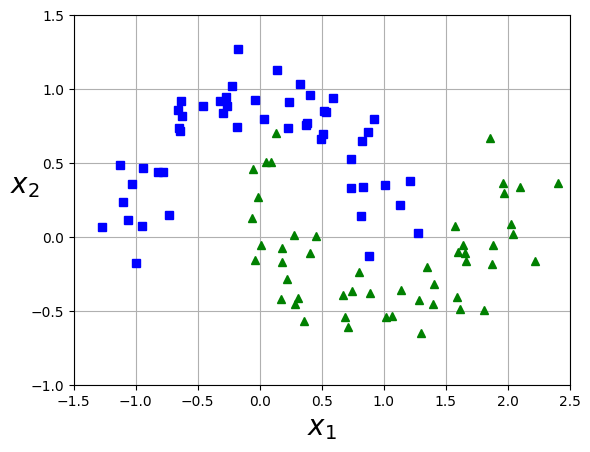

In [24]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

/Users/sensio/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

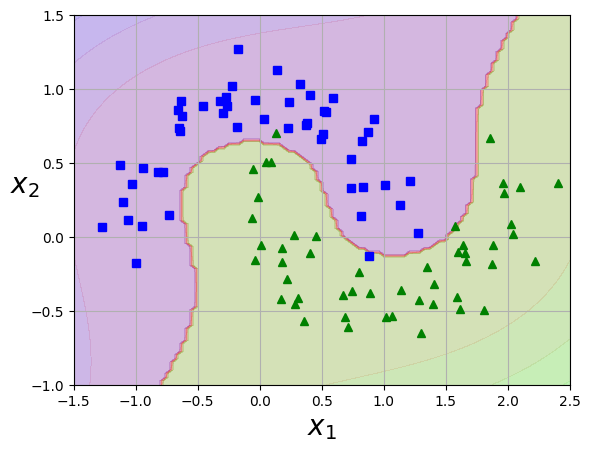

In [26]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

Las SVM tienen la capacidad de entrenar con características polinómicas sin requerirlas explícitamente, lo que conlleva un aumento en el rendimiento. Esta técnica matemática se conoce como el *truco del kernel*, o *kernel trick*.


In [27]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [28]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

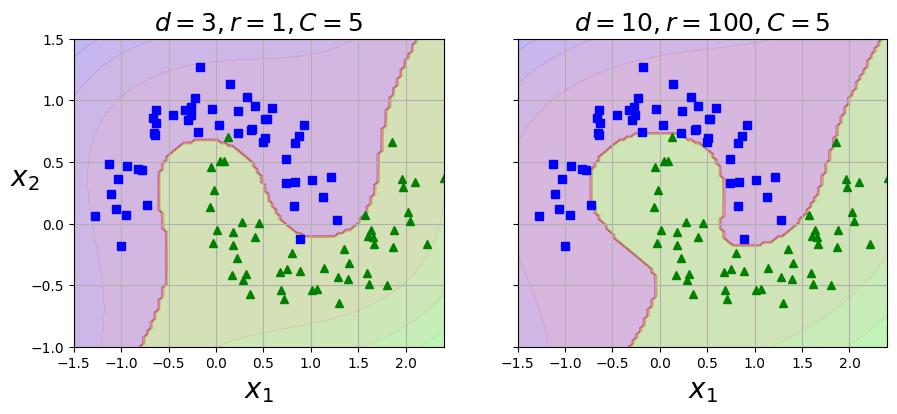

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

La mejor manera de encontrar la combinación correcta de hiperparámetros es utilizar la búsqueda en cuadrícula.

Otra técnica para abordar problemas no lineales es agregar características calculadas utilizando una función de similitud, que mide cuánto se parece cada instancia a un punto de referencia particular.

Utilizando la siguiente función de similitud (Función de Base Radial Gaussiana, RBF)

$$
  \phi_\gamma(\mathbf{x}, l) = e^{-\gamma || \mathbf{x}-l||^2}
$$

Podemos separar el conjunto de datos de ejemplo 1D anterior con puntos de referencia en $x_1=-2$ y $x_1 = 1$ y $\gamma = 0.3$.

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/svm_kernel_gauss.png)

La forma más simple de seleccionar puntos de referencia es asignar uno a cada instancia del conjunto de datos. De esta manera, aumentamos la posibilidad de que el conjunto de datos sea linealmente separable, pero con tantas características como muestras en el conjunto de datos. Podemos usar el *truco del kernel* para entrenar SVMs con funciones de similitud.

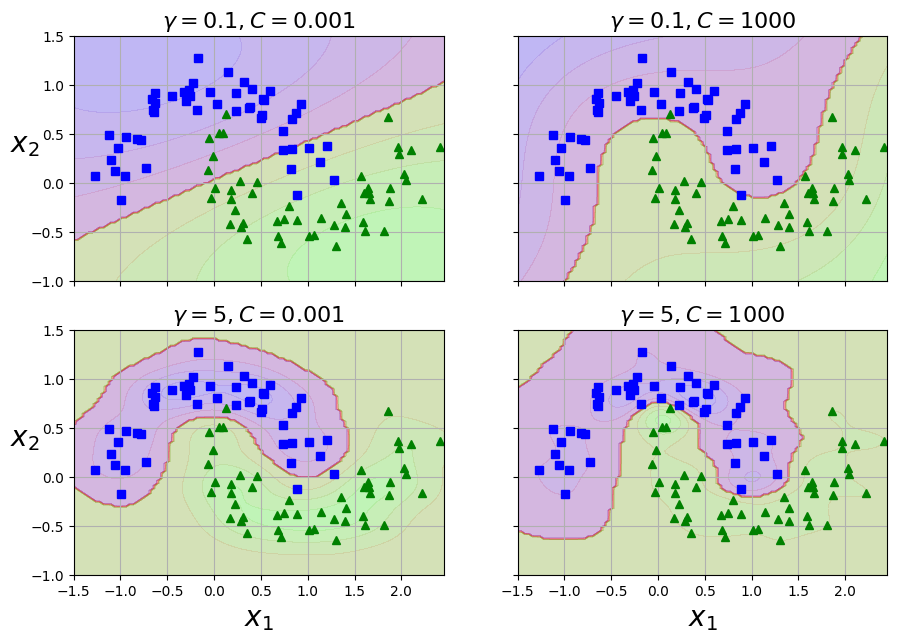

In [30]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

Existen otros kernels, pero se utilizan con mucha menos frecuencia. Algunos kernels están especializados para ciertas tareas, como los *string kernels* que se utilizan para clasificar documentos de texto o secuencias de ADN.

Imaginemos que queremos aplicar una transformación polinomial de segundo grado a un conjunto de entrenamiento bidimensional.

$$
  \phi(\mathbf{x}) = \phi \left( \left(
    \begin{array}{c}
      x_1 \\ x_2
     \end{array} \right) \right) = \left(
       \begin{array}{c}
      x_1^2 \\ \sqrt{2} x_1 x_2 \\ x_2^2
     \end{array} \right)
$$

Si aplicamos esta transformación a dos vectores y calculamos su producto escalar, obtenemos

$$
  \phi(\mathbf{a})^T \phi(\mathbf{b}) = \left(
       \begin{array}{c}
      a_1^2 \\ \sqrt{2} a_1 a_2 \\ a_2^2
     \end{array} \right)^T \left(
       \begin{array}{c}
      b_1^2 \\ \sqrt{2} b_1 b_2 \\ b_2^2
     \end{array} \right) = 
     a_1^2 b_1^2 + 2 a_1 b_1 a_2 b_2 + a_2^2 b_2^2 = 
     (a_1 b_1 + a_2 b_2)^2 = \left( \left(
       \begin{array}{c}
      a_1 \\ a_2
     \end{array} \right)^T \left(
       \begin{array}{c}
      b_1 \\ b_2
     \end{array} \right) \right)^2 = 
     (\mathbf{a}^T \mathbf{b})^2
$$

El producto escalar de los vectores transformados es igual al cuadrado del producto escalar de los vectores originales, $\phi(\mathbf{a})^T \phi(\mathbf{b}) =(\mathbf{a}^T \mathbf{b})^2$. Si aplicas la transformación $\phi$ a todas las instancias de entrenamiento, entonces el *problema dual* contendrá el producto escalar de los vectores transformados. Puedes reemplazar este producto escalar para no tener que transformar las instancias en absoluto. Para que el truco funcione, la transformación debe ser un *kernel*, una función capaz de calcular el producto escalar basándose únicamente en los vectores originales sin necesidad de conocer la transformación. Algunos ejemplos son:

$$
  \begin{array}{rl}
    \textrm{Linear}: & K(\mathbf{a},\mathbf{b}) = \mathbf{a}^T \mathbf{b} \\
    \textrm{Plynomial}: & K(\mathbf{a},\mathbf{b}) = (\gamma \mathbf{a}^T \mathbf{b} + r)^d \\
    \textrm{Gaussina RBF}: & K(\mathbf{a},\mathbf{b}) = exp
    (-\gamma || \mathbf{a} - \mathbf{b} ||^2) \\
    \textrm{Sigmoid}: & K(\mathbf{a},\mathbf{b}) = \textrm{tanh} (\gamma \mathbf{a}^T \mathbf{b} + r)\\
  \end{array}
$$

Finalmente, para obtener predicciones

$$
  h_{\hat{\mathbf{w}},\hat{b}} ( \phi(\mathbf{x}^{(n)})) = \sum_{j=1, \hat{\alpha}^{(j)} > 0}^N \hat{\alpha}^{(j)} t^{(j)} K(\mathbf{x}^{(j)}, \mathbf{x}^{(n)}) + \hat{b}
$$

donde $\hat{b} = 1/N \sum_{i=1, \hat{\alpha}^{(i)} > 0}^N (t^{(i)} - \sum_{j=1, \hat{\alpha}^{(j)} > 0}^N \hat{\alpha}^{(j)} t^{(j)} K(\mathbf{x}^{(i)},\mathbf{x}^{(j)}))$. Nótese que para hacer predicciones solo tenemos que calcular los productos escalares de la nueva instancia con los vectores de soporte ($\alpha^{(j)} \neq 0$).

## Regresión


La regresión con SVM funciona invirtiendo la función objetivo. En lugar de intentar ajustar el margen más ancho posible entre dos clases mientras se limitan las violaciones del margen, la regresión SVM intenta ajustar tantas instancias como sea posible dentro del margen.

In [31]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [32]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [33]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

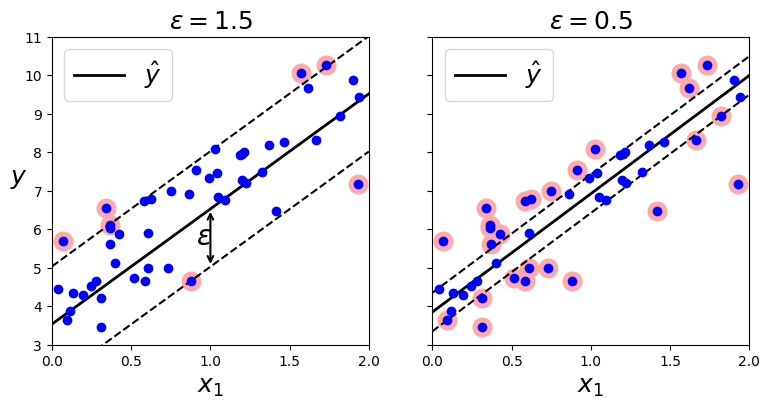

In [34]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

Agregar más instancias dentro del margen no afecta las predicciones del modelo.

El *truco del kernel* aún se puede utilizar para abordar datos no lineales.

In [35]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [36]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

In [37]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

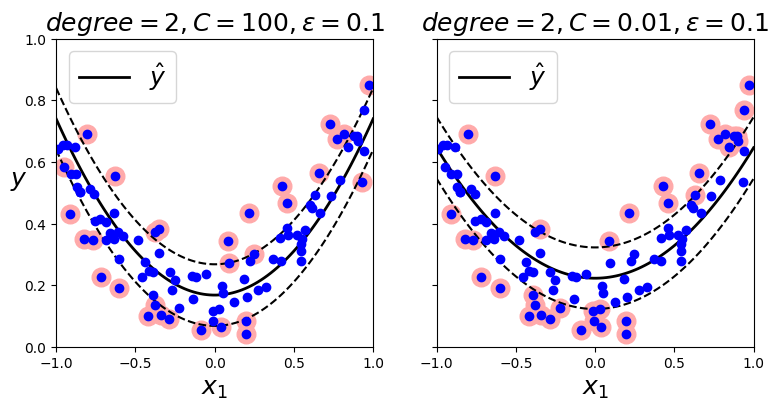

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

De nuevo, la mejor manera de encontrar el conjunto de hiperparámetros óptimos será la búsqueda en malla o aleatoria.